In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data.csv")
print(data.shape)
data

(317, 12)


,District,AQI,Precipitation,GDP,Temperature,Longitude,Latitude,Altitude,PopulationDensity,Coastal,GreenCoverageRate,Incineration
0,中西區,23,665.1,271.13,8.200000,102.224650,31.899410,2617.0,11,0,36.00,23.00
1,南區,137,80.4,610.00,12.276712,80.263380,41.167540,1108.0,6547,0,33.94,23.00
2,東區,85,150.0,322.58,24.200000,105.728950,38.851920,1673.0,1,0,36.00,23.00
3,觀塘,28,74.2,37.40,1.000000,80.105800,32.501110,4280.0,1,0,36.00,23.00
4,深水埗,79,2127.8,1613.20,17.291781,117.034431,30.512646,13.0,2271,0,45.80,27.48
...,...,...,...,...,...,...,...,...,...,...,...,...
312,塔門,79,1388.0,1807.09,15.946575,114.035690,32.979042,84.0,2539,0,39.46,18.86
313,銅鑼灣,86,807.8,1270.40,16.182192,104.650190,30.122671,367.0,1787,0,38.67,18.28
314,中環,116,288.0,4130.20,14.576712,118.056053,36.793579,38.0,782,0,36.00,31.00
315,旺角,118,994.8,1143.11,19.432877,104.776352,29.367722,311.0,1557,0,40.20,35.47


## 空氣質量預測

### 基模型
首先我們不做任何處理建立基礎模型，之後在改造看效果。

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data.drop(["District", "AQI"], axis=1)
y = data["AQI"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)

In [4]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)

print("實際值：", y_test[:5].values)
print("預測值：", y_hat[:5])
print("訓練集R^2：",lr.score(X_train, y_train))
print("測試集R^2：",lr.score(X_test, y_test))

實際值： [62 24 44 16 88]
預測值： [109.54497604  20.70283818  95.1031786   47.57703917  89.6555943 ]
訓練集R^2： 0.45634596561464025
測試集R^2： 0.4179617826627


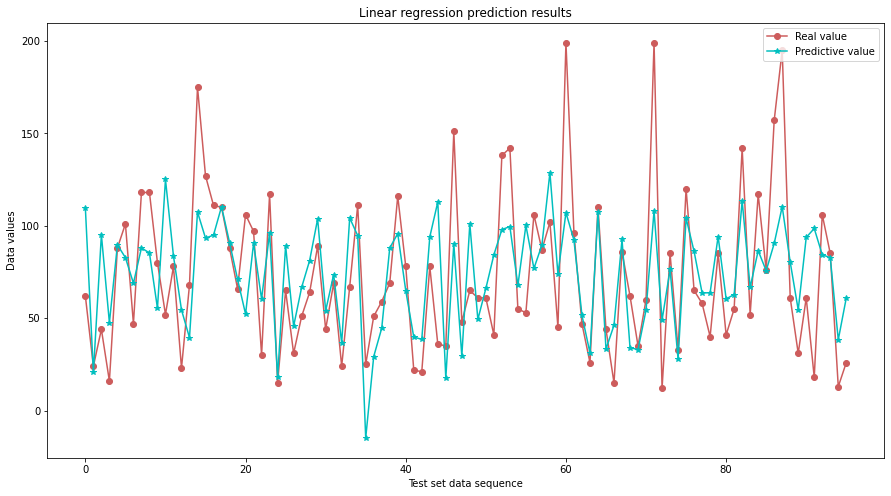

In [5]:
# 繪製預測結果圖
plt.figure(figsize=(15, 8))
plt.plot(y_test.values, label="Real value", color="indianred", marker="o")
plt.plot(y_hat, label="Predictive value", color="c", marker="*")
plt.xlabel("Test set data sequence")
plt.ylabel("Data values")
plt.title("Linear regression prediction results", fontsize=12)
plt.legend(loc=1)
plt.savefig('predict_result.png')

#### 進行特征選擇

In [6]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=lr,step=1,cv=5,n_jobs=-1,scoring="r2")
# estimator：要操作的模型
# step：每次刪除的特征數量
# cv：使用交叉驗證的折數
# n_jobs：並發的數量
# scoring：評估方式
rfecv.fit(X_train, y_train)
# 返回經過選擇之後，剩餘的特征數量
print("剩餘特征數量:",rfecv.n_features_)
# 返回經過特征選擇後，使用縮減特征訓練的模型
print(rfecv.estimator_)
# 返回每個特征的等級，數值越小等級越重要
print("特征等級:",rfecv.ranking_)
# 返回布爾數組，看特征是否被選擇
print("特征是否被選擇:",rfecv.support_)
# 返回對應數量特征時，模型交叉驗證的得分
print("交叉驗證得分:",rfecv.grid_scores_)

剩餘特征數量: 8
LinearRegression()
特征等級: [1 2 1 1 1 1 3 1 1 1]
特征是否被選擇: [ True False  True  True  True  True False  True  True  True]
交叉驗證得分: [0.17927437 0.31223187 0.34978893 0.33849708 0.35198834 0.3461472
 0.3615249  0.36289154 0.33617978 0.34049761]


刪除兩個特征影響不大。

對重選特征測試。

In [7]:
print("選擇的變量：", X_train.columns[rfecv.support_])
print("剔除的變量：", X_train.columns[~rfecv.support_])
X_train_eli = rfecv.transform(X_train)
X_test_eli = rfecv.transform(X_test)
print(rfecv.estimator_.score(X_train_eli, y_train))
print(rfecv.estimator_.score(X_test_eli, y_test))

選擇的變量： Index(['Precipitation', 'Temperature', 'Longitude', 'Latitude', 'Altitude',
       'Coastal', 'GreenCoverageRate', 'Incineration'],
      dtype='object')
剔除的變量： Index(['GDP', 'PopulationDensity'], dtype='object')
0.45178952850835274
0.413630742895043


剩餘特征數量: 8
LinearRegression()
特征的等級: [1 2 1 1 1 1 3 1 1 1]
特征是否被選擇: [ True False  True  True  True  True False  True  True  True]
交叉驗證得分: [0.17927437 0.31223187 0.34978893 0.33849708 0.35198834 0.3461472
 0.3615249  0.36289154 0.33617978 0.34049761]


Text(0, 0.5, '交叉驗證$R^2$值')

/Users/maxine/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/maxine/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/maxine/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/maxine/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
Font 'default' does not have a glyph for '\u4ea4' [U+4ea4], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u53c9' [U+53c9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9a57' [U+9a57], 

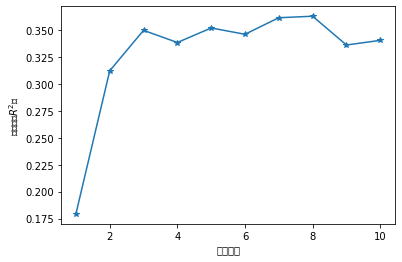

In [8]:
# 再次进行特征选择，并绘制交叉验证的得分情况
rfecv = RFECV(estimator=lr,step=1,cv=5,n_jobs=-1,scoring="r2")
rfecv.fit(X_train, y_train)
print("剩餘特征數量:",rfecv.n_features_)
print(rfecv.estimator_)
print("特征的等級:",rfecv.ranking_)
print("特征是否被選擇:",rfecv.support_)
print("交叉驗證得分:",rfecv.grid_scores_)

# 绘制交叉验证的得分情况
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker="*")
plt.xlabel("特征數量")
plt.ylabel("交叉驗證$R^2$值")

In [9]:
print("選擇的變量：", X_train.columns[rfecv.support_])
print("剔除的變量：", X_train.columns[~rfecv.support_])
X_train_eli = X_train[X_train.columns[rfecv.support_]]
X_test_eli = X_test[X_test.columns[rfecv.support_]]
print(rfecv.estimator_.score(X_train_eli, y_train))
print(rfecv.estimator_.score(X_test_eli, y_test))

選擇的變量： Index(['Precipitation', 'Temperature', 'Longitude', 'Latitude', 'Altitude',
       'Coastal', 'GreenCoverageRate', 'Incineration'],
      dtype='object')
剔除的變量： Index(['GDP', 'PopulationDensity'], dtype='object')
0.45178952850835274
0.413630742895043


經過特徵選擇，剔除掉了'GDP'與'PopulationDensity'兩個特徵，使用剩下的時隙特徵訓練出的模型細節與剔除前的模型相似幾乎相同。說明我們剔除的這兩個特徵，確實對模型擬合的目標沒有什麼幫助，可以去掉。

分箱操作
注意：分箱後，我們不能講每個區間映射為離散值，而適當使用One-Hot編碼

In [10]:
from sklearn.preprocessing import KBinsDiscretizer
k = KBinsDiscretizer(n_bins=[4, 5, 14, 6],
                     encode="onehot-dense",
                     strategy="uniform")

discretize = ["Longitude", "Temperature", "Precipitation", "Latitude"]

r = k.fit_transform(X_train_eli[discretize])
r = pd.DataFrame(r, index=X_train_eli.index)
# Obtain other features besides discrete features.
X_train_dis = X_train_eli.drop(discretize, axis=1)
# The discretized features are recombined with other features.
X_train_dis = pd.concat([X_train_dis, r], axis=1)
# The same discretization operation is performed for the test set.
r = pd.DataFrame(k.transform(X_test_eli[discretize]), index=X_test_eli.index)
X_test_dis = X_test_eli.drop(discretize, axis=1)
X_test_dis = pd.concat([X_test_dis, r], axis=1)
# View the format after the conversion.
display(X_train_dis.head())

,Altitude,Coastal,GreenCoverageRate,Incineration,0,1,2,3,4,5,...,19,20,21,22,23,24,25,26,27,28
27,189.0,0,39.56,21.78,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
167,791.0,0,36.00,23.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
274,321.0,0,38.22,29.21,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37,149.0,0,43.70,43.64,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54,146.0,0,34.24,29.20,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# training
lr.fit(X_train_dis, y_train)
print("訓練集R^2：", lr.score(X_train_dis, y_train))
print("測試集R^2：", lr.score(X_test_dis, y_test))

訓練集R^2： 0.6228876365383831
測試集R^2： 0.5437609313595555


可以看到，經過離散化處理之後，我們的模型效果又得到了一定程度的提升